### 話者コードによる複数話者モデル(入力層へ)の構築
nnmnkwii (nanami)による音声合成スクリプト

In [2]:
# import packages
%pylab inline
rcParams["figure.figsize"]=(16,5)
from nnmnkwii.datasets import FileDataSource ,FileSourceDataset
from nnmnkwii.datasets import MemoryCacheFramewiseDataset
from nnmnkwii.preprocessing import trim_zeros_frames,remove_zeros_frames
from nnmnkwii.preprocessing import minmax, meanvar, minmax_scale,scale
from nnmnkwii import paramgen
from nnmnkwii.io import hts
from nnmnkwii.frontend import merlin as fe
from nnmnkwii.postfilters import merlin_post_filter

from os.path import join ,expanduser, basename, splitext,exists, dirname
import os
import pickle
from glob import glob 
from scipy.io import wavfile
import wave
import array
from sklearn.model_selection import train_test_split
import pyworld
import pysptk
import librosa
import librosa.display
import IPython
from IPython.display import Audio

Populating the interactive namespace from numpy and matplotlib


In [3]:
#prepare data
SPEAKER_DIR = 'FTS'
DATA_ROOT=join("./Synth_uudb/data/",SPEAKER_DIR)
question_file_path = join(DATA_ROOT,"question4uudb_out_BD.hed")
# Save generated wav files for later comparison
save_root_dir = join('./Synth_uudb/generated_spid-multi-FT/',SPEAKER_DIR)
#! ./nnmnkwii_gallery/scripts/download_data.sh slt_arctic_full_data
!python ./Synth_uudb/script/prepare_features.py $DATA_ROOT --use_phone_alignment --question_path $question_file_path
random_state=1234
# モデル構築時に学習に用いるデータの総数
train_data_num = 1195
test_size = 0.01

Features for duration model training found, skipping feature extraction.
Features for acousic model training found, skipping feature extraction.


In [4]:
# set params
mgc_dim = 35*3
lf0_dim    = 3
vuv_dim   = 1
bap_dim   = 3

duration_linguistic_dim  = 385
acoustic_linguistic_dim  = duration_linguistic_dim + 4
duration_dim = 1
acoustic_dim = mgc_dim + lf0_dim + vuv_dim + bap_dim

fs = 16000 # sampling frequency :16kHz
frame_period = 5 # frame shift :5ms 
hop_length = 80 
fftlen = 1024
alpha = 0.42

mgc_start_idx = 0
lf0_start_idx = 105
vuv_start_idx = 108
bap_start_idx = 109

windows = [
    (0, 0, np.array([1.0])),
    (1, 1, np.array([-0.5, 0.0, 0.5])),
    (1, 1, np.array([1.0, -2.0, 1.0])),
]

In [5]:
# fileopener
class BinaryFileSource(FileDataSource):
    def __init__(self,data_root,dim,train,train_data_num,speaker_list):
            self.data_root = data_root
            self.dim = dim 
            self.train = train
            self.files = data_root
            self.train_data_num = train_data_num
            self.data_duration = 0
            self.speaker_list = speaker_list
            # For DEBUG
            #self.speaker_list = []
            
    def collect_files(self):
            #files = sorted(glob(join(self.data_root, "*.bin")))
            files = self.files[:self.train_data_num] 
            train_files,test_files = train_test_split(files,test_size = test_size, random_state = random_state)
            if self.train:
                #継続時間長の取得
                get_duration=lambda y:sorted(map(lambda x:int(x.split(' ')[1]),y))[-1]*10**-7
                root_dir = dirname(dirname(self.data_root[0]))
                tmp_files = list(map(lambda x:join(root_dir,'label_phone_align',x),sorted(map(lambda x:basename(x).replace('.bin','.lab'),train_files))))
                for file in tmp_files:
                    with open(file,'r')as f:
                        data = f.readlines()
                        self.data_duration += get_duration(data)
                return train_files
            else:
                return test_files
    def collect_features(self,path):
            org_data = np.fromfile(path,dtype = np.float32).reshape(-1,self.dim)
            # 話者コードを付加する
            if len(self.speaker_list)>0:
                spid = basename(path).split('_')[0]
                org_data = np.fromfile(path,dtype = np.float32).reshape(-1,self.dim)
                spid_vec = np.zeros(len(self.speaker_list),dtype = np.float32)
                spid_vec[self.speaker_list.index(spid)] = 1.0
                data = np.c_[org_data,[spid_vec]*org_data.shape[0]]
                #print(spid,data[:,-5:])
                return data
            else:
                return org_data

In [6]:
# load_data and make matrix
X = {"duration":{},"acoustic":{}}
Y = {"duration":{},"acoustic":{}}
utt_lengths = {"duration":{},"acoustic":{}}
utt_dur_lengths = {"duration":{},"acoustic":{}}


# 全学習データ
all_datafiles = sorted(glob(join(DATA_ROOT+'/X_{}/*.bin'.format("duration"))))
# 538発話(C002L~C007L)を学習データ, 残り89発話(C001)をテストデータとしている
#train_files, all_test_files = train_test_split(all_datafiles,test_size = 0.3, random_state = random_state)
train_basenames = list(map(lambda x:basename(x).replace('.lab','.bin'),sorted(glob(join(DATA_ROOT, 'label_phone_align/*.lab')))))
test_label_paths =sorted(glob(join(DATA_ROOT, "test_label_phone_align/", "*.lab")))
print('train:',len(train_basenames),'test:',len(test_label_paths))
speaker_list = ['FTH','FMS','FNN']+list(set(list(map(lambda x:x.split('_')[0],train_basenames))))
print('speaker_list:',speaker_list)
for ty in ["duration","acoustic"]:
    for phase in ["train","test"]:
        train = phase == "train"
        x_dim = duration_linguistic_dim if ty == "duration" else acoustic_linguistic_dim
        y_dim = duration_dim if ty == "duration" else acoustic_dim
        
        train_x = BinaryFileSource(list(map(lambda x:join(DATA_ROOT,'X_{}/{}'.format(ty,x)) ,train_basenames)), dim =x_dim, train=train, train_data_num=train_data_num, speaker_list=speaker_list)
        train_y = BinaryFileSource(list(map(lambda x:join(DATA_ROOT,'Y_{}/{}'.format(ty,x)) ,train_basenames)) ,dim=y_dim, train=train, train_data_num=train_data_num, speaker_list=[])
        
        X[ty][phase] = FileSourceDataset(train_x)
        Y[ty][phase] = FileSourceDataset(train_y)
        
        # this triggers file loads, but can be neglectable in terms of performance.
        utt_lengths[ty][phase] = [len(x) for x in X[ty][phase]]
        utt_dur_lengths[ty][phase] = train_x.data_duration


train: 538 test: 89
speaker_list: ['FTH', 'FMS', 'FNN', 'FTS']


In [7]:
print(X['duration']['train'].__len__(),X['duration']['test'].__len__())
print(X['duration']['train'][0],Y['duration']['train'][0])

532 6
[[0. 0. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [1. 1. 0. ... 0. 0. 1.]
 [1. 0. 0. ... 0. 0. 1.]] [[14.]
 [14.]
 [ 8.]
 [12.]
 [22.]
 [12.]
 [ 8.]
 [10.]
 [12.]
 [16.]
 [22.]
 [12.]
 [12.]
 [12.]
 [10.]
 [14.]
 [12.]
 [16.]
 [10.]
 [14.]
 [10.]
 [10.]]


Total number of utterances: 532
Total number of frames: 10758


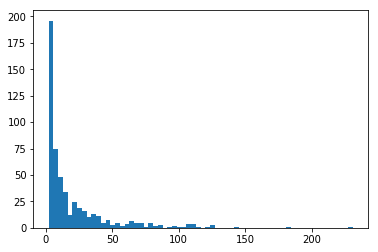

In [8]:
# Utterance length duration
print("Total number of utterances:", len(utt_lengths["duration"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["duration"]["train"]))
hist(utt_lengths["duration"]["train"], bins=64);

Total number of utterances: 532
Total number of frames: 181826


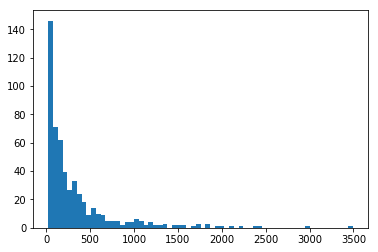

In [9]:
# Utterance length acoustic
print("Total number of utterances:", len(utt_lengths["acoustic"]["train"]))
print("Total number of frames:", np.sum(utt_lengths["acoustic"]["train"]))
hist(utt_lengths["acoustic"]["train"], bins=64);

In [10]:
# how data look lile ?
def vis_utterance(X, Y, lengths, idx):
    """ Visualize the following features:
    1. Linguistic features
    2. Spectrogram
    3. Log-F0
    4. Aperiodicity
    """
    x = X[idx][:lengths[idx]]
    y = Y[idx][:lengths[idx]]
    
    figure(figsize = (16,20))
    # Linguistic features
    subplot(4,1,1)
    librosa.display.specshow(x.T, sr = fs, hop_length = hop_length, x_axis = "time")
    # Spectrogram
    subplot(4,1,2)
    logsp = np.log(pysptk.mc2sp(y[ : , mgc_start_idx:mgc_dim//len(windows)], alpha = alpha, fftlen = fftlen))
    librosa.display.specshow(logsp.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")
    # lLog-F0
    subplot(4,1,3)
    lf0 = y[: , lf0_start_idx]
    vuv = y[: , vuv_start_idx]
    plot(lf0, linewidth = 2, label = "Continuous log -f0")
    plot(vuv, linewidth = 2, label = "Voiced/unvoiced flag")
    legend(prop = {"size": 14}, loc = "upper right")
    # Aperiodicity
    subplot(4,1,4)
    bap = y[:,bap_start_idx:bap_start_idx+bap_dim//len(windows)]
    bap = np.ascontiguousarray(bap).astype(np.float64)
    aperiodicity = pyworld.decode_aperiodicity(bap, fs, fftlen)
    librosa.display.specshow(aperiodicity.T, sr=fs, hop_length=hop_length, x_axis="time", y_axis="linear")

/usr/local/anaconda3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


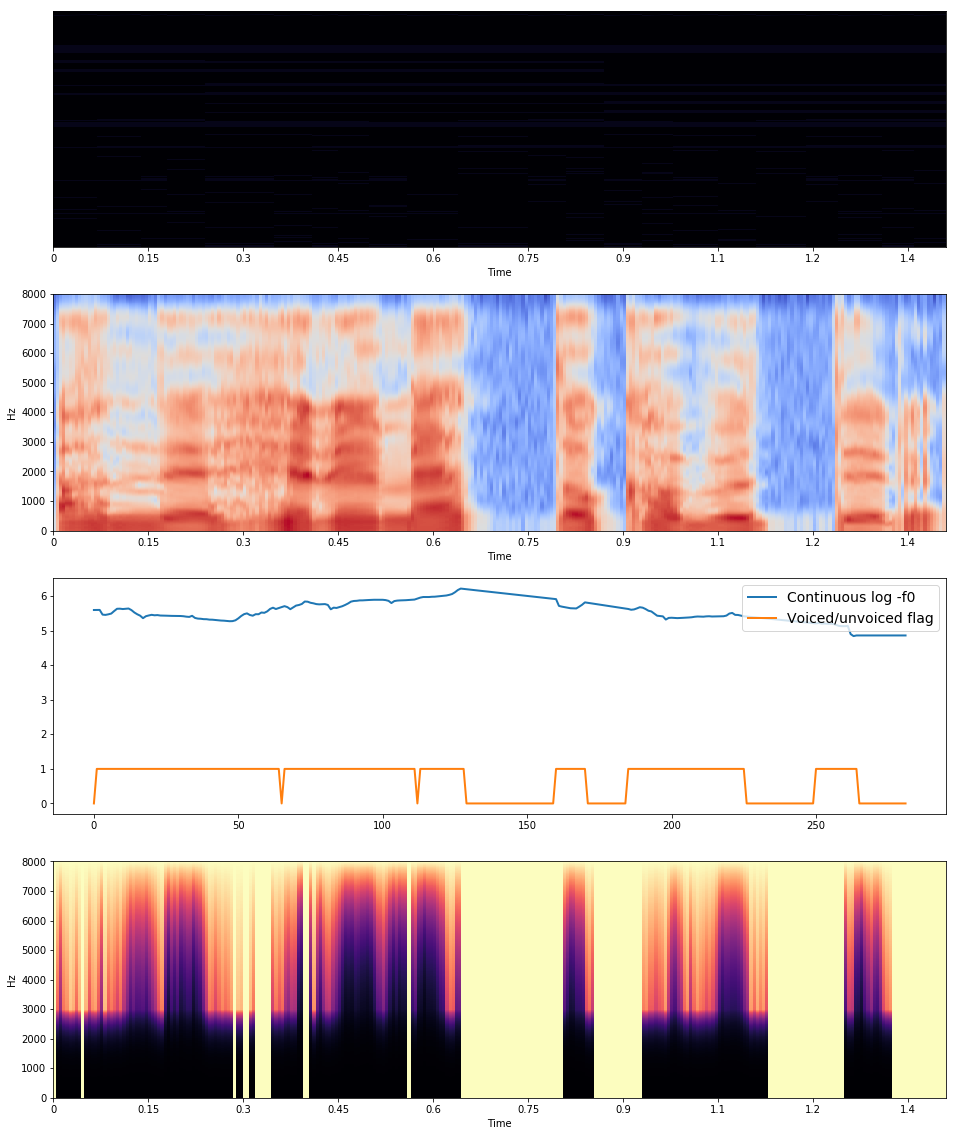

In [11]:
# 1番目の発話の音響分析
idx=0
vis_utterance(X["acoustic"]["train"], Y["acoustic"]["train"], utt_lengths["acoustic"]["train"], idx)

In [12]:
# Statistics(data normalize)
X_min = {}
X_max = {}
Y_mean = {}
Y_var = {}
Y_scale = {}

for typ in ["acoustic", "duration"]:
    X_min[typ], X_max[typ] = minmax(X[typ]["train"], utt_lengths[typ]["train"])
    Y_mean[typ], Y_var[typ] = meanvar(Y[typ]["train"], utt_lengths[typ]["train"])
    Y_scale[typ] = np.sqrt(Y_var[typ])

/usr/local/anaconda3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


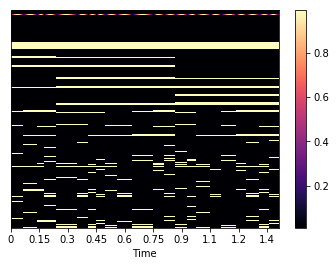

In [13]:
# view Linguistic features
idx = 0
typ = "acoustic"
x = X[typ]["train"][idx][:utt_lengths[typ]["train"][idx]]
x = minmax_scale(x, X_min[typ], X_max[typ], feature_range=(0.01, 0.99))
librosa.display.specshow(x.T, sr=fs, hop_length=hop_length, x_axis="time")
colorbar()

In [14]:
# using pytorch 
from torch.utils import data as data_utils
import torch

class PyTorchDataset(torch.utils.data.Dataset):
    """Thin dataset wrapper for pytorch

    This does just two things:
        1. On-demand normalization
        2. Returns torch.FlaotTensor instead of numpy.ndarray
    """
    def __init__(self, X, Y, X_min, X_max, Y_mean, Y_scale):
        self.X, self.Y = X, Y
        self.X_min, self.X_max = X_min, X_max
        self.Y_mean, self.Y_scale = Y_mean, Y_scale
    def __getitem__(self, idx):
        x, y = self.X[idx], self.Y[idx]
        x = minmax_scale(x, self.X_min, self.X_max, feature_range=(0.01, 0.99))
        y = scale(y, self.Y_mean, self.Y_scale)
        x, y = torch.from_numpy(x), torch.from_numpy(y)
        return x, y
    def __len__(self):
        return len(self.X)

In [15]:
# Model
import torch
from torch import nn
from torch.autograd import Variable
from tqdm import tnrange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim

In [16]:
class MyNet(torch.nn.Module):
    """Very simple deep neural networks.
    """
    def __init__(self, D_in, H, D_out, num_layers=2):
        super(MyNet, self).__init__()
        self.first_linear = nn.Linear(D_in, H)
        self.hidden_layers = nn.ModuleList(
            [nn.Linear(H, H) for _ in range(num_layers)])
        #self.hidden_dropout_layer = F.dropout()
        self.last_linear = nn.Linear(H, D_out)
        self.relu = nn.Tanh()

    def forward(self, x):
        h = self.relu(self.first_linear(x))
        for hl in self.hidden_layers:
            h = self.relu(hl(h))
        return self.last_linear(h)

In [29]:
num_hidden_layers={}
num_hidden_layers["duration"] = 3
num_hidden_layers["acoustic"] = 3
hidden_size={}
hidden_size["duration"] = 64
hidden_size["acoustic"] = 64
batch_size = 256
# We use PyTorch's multiprocess iterator. Note that large n_workers causes
# dataset copies across proccess.
n_workers = 8
pin_memory = True
nepoch = 50
lr = 0.001
weight_decay = 1e-6
use_cuda = torch.cuda.is_available()
print(use_cuda)
# save dir
save_dir = join(save_root_dir,f'speech_{train_data_num}_lay{num_hidden_layers["duration"]}_{num_hidden_layers["acoustic"]}_size{hidden_size["duration"]}_{hidden_size["acoustic"]}_ep{nepoch}_lr{lr}_bs{batch_size}')
if not exists(save_dir):
    os.makedirs(save_dir)

True


In [30]:
def train(model, optimizer, X, Y, X_min, X_max, Y_mean, Y_scale,
          utt_lengths, cache_size=1000):
    if use_cuda:
        model = model.cuda()

    X_train, X_test = X["train"], X["test"]
    Y_train, Y_test = Y["train"], Y["test"]
    train_lengths, test_lengths = utt_lengths["train"], utt_lengths["test"]

    # Frame-wise train data loader
    X_train_cache_dataset = MemoryCacheFramewiseDataset(
        X_train, train_lengths, cache_size)
    Y_train_cache_dataset = MemoryCacheFramewiseDataset(
        Y_train, train_lengths, cache_size)
    train_dataset = PyTorchDataset(X_train_cache_dataset, Y_train_cache_dataset,
                                  X_min, X_max, Y_mean, Y_scale)
    train_loader = data_utils.DataLoader(
        train_dataset, batch_size=batch_size, num_workers=n_workers,
        pin_memory=pin_memory, shuffle=True)
    print("Train dataset number of frames", len(train_dataset))

    # Frame-wise test data loader
    X_test_cache_dataset = MemoryCacheFramewiseDataset(
        X_test, test_lengths, cache_size)
    Y_test_cache_dataset = MemoryCacheFramewiseDataset(
        Y_test, test_lengths, cache_size)
    test_dataset = PyTorchDataset(X_test_cache_dataset, Y_test_cache_dataset,
                                 X_min, X_max, Y_mean, Y_scale)
    test_loader = data_utils.DataLoader(
        test_dataset, batch_size=batch_size, num_workers=n_workers,
        pin_memory=pin_memory, shuffle=False)
    print("Test dataset numer of frames", len(test_dataset))

    dataset_loaders = {"train": train_loader, "test": test_loader}

    # Training loop
    criterion = nn.MSELoss()
    model.train()
    print("Start frame-wise training...")
    loss_history = {"train": [], "test": []}
    for epoch in tnrange(nepoch):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for x, y in dataset_loaders[phase]:
                if use_cuda:
                    x, y = x.cuda(), y.cuda()
                x, y = Variable(x), Variable(y)
                optimizer.zero_grad()
                y_hat = model(x)
                loss = criterion(y_hat, y)
                if phase == "train":
                    loss.backward()
                    optimizer.step()
                running_loss += loss.data[0]
            loss_history[phase].append(running_loss / len(dataset_loaders[phase]))

    return loss_history

In [19]:
models = {}
for typ in ["duration", "acoustic"]:
    models[typ] = MyNet(X[typ]["train"][0].shape[-1],
                            hidden_size[typ], Y[typ]["train"][0].shape[-1],
                            num_hidden_layers[typ])
    print("Model for {}\n".format(typ), models[typ])

Model for duration
 MyNet (
  (first_linear): Linear (389 -> 64)
  (hidden_layers): ModuleList (
    (0): Linear (64 -> 64)
    (1): Linear (64 -> 64)
    (2): Linear (64 -> 64)
  )
  (last_linear): Linear (64 -> 1)
  (relu): Tanh ()
)
Model for acoustic
 MyNet (
  (first_linear): Linear (393 -> 64)
  (hidden_layers): ModuleList (
    (0): Linear (64 -> 64)
    (1): Linear (64 -> 64)
    (2): Linear (64 -> 64)
  )
  (last_linear): Linear (64 -> 112)
  (relu): Tanh ()
)


In [20]:
with open('./Synth_uudb/generated_spid-multi/FTH_FMS_FNN/speech_1195_lay3_3_size64_64_ep50_lr0.001_bs256/uudb_result.dat','rb')as f:
    result = pickle.load(f)
models["duration"] = result['speech_1195_lay3_3_size64_64_ep50_lr0.001_bs256'][1]["duration"]
models["acoustic"] = result['speech_1195_lay3_3_size64_64_ep50_lr0.001_bs256'][1]["acoustic"]

In [21]:
ty = "duration"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Train dataset number of frames 10758
Test dataset numer of frames 61
Start frame-wise training...


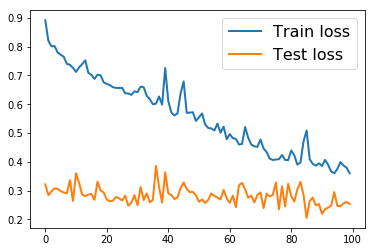

In [22]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})
savefig('{}/duration_model_{}_{}_lr{}_epoch{}.png'.format(save_dir,num_hidden_layers["duration"],hidden_size["duration"],lr,nepoch))

In [31]:
ty = "acoustic"
optimizer = optim.Adam(models[ty].parameters(), lr=lr, weight_decay=weight_decay)
loss_history = train(models[ty], optimizer, X[ty], Y[ty],
                     X_min[ty], X_max[ty], Y_mean[ty], Y_scale[ty], utt_lengths[ty])

Train dataset number of frames 181826
Test dataset numer of frames 948
Start frame-wise training...


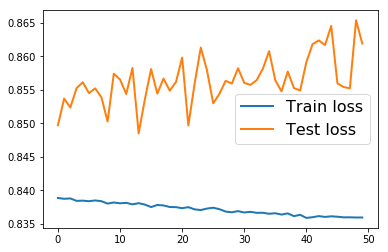

In [32]:
plot(loss_history["train"], linewidth=2, label="Train loss")
plot(loss_history["test"], linewidth=2, label="Test loss")
legend(prop={"size": 16})
savefig('{}/acoustic_model_{}_{}_lr{}_epoch{}.png'.format(save_dir,num_hidden_layers["acoustic"],hidden_size["acoustic"],lr,nepoch))

In [25]:
binary_dict, continuous_dict = hts.load_question_set(
    join(DATA_ROOT, basename(question_file_path)))

def gen_parameters(y_predicted):
    # Number of time frames
    T = y_predicted.shape[0]

    # Split acoustic features
    mgc = y_predicted[:,:lf0_start_idx]
    lf0 = y_predicted[:,lf0_start_idx:vuv_start_idx]
    vuv = y_predicted[:,vuv_start_idx]
    bap = y_predicted[:,bap_start_idx:]

    # Perform MLPG
    ty = "acoustic"
    mgc_variances = np.tile(Y_var[ty][:lf0_start_idx], (T, 1))
    mgc = paramgen.mlpg(mgc, mgc_variances, windows)
    lf0_variances = np.tile(Y_var[ty][lf0_start_idx:vuv_start_idx], (T,1))
    lf0 = paramgen.mlpg(lf0, lf0_variances, windows)
    bap_variances = np.tile(Y_var[ty][bap_start_idx:], (T, 1))
    bap = paramgen.mlpg(bap, bap_variances, windows)

    return mgc, lf0, vuv, bap

def gen_waveform(y_predicted, do_postfilter=False):
    y_predicted = trim_zeros_frames(y_predicted)

    # Generate parameters and split streams
    mgc, lf0, vuv, bap = gen_parameters(y_predicted)

    if do_postfilter:
        mgc = merlin_post_filter(mgc, alpha)
    
    # 客観評価用のためにパラメータを保存
    params = {'mgc':mgc, 'lf0':lf0, 'vuv':vuv, 'bap':bap}

    spectrogram = pysptk.mc2sp(mgc, fftlen=fftlen, alpha=alpha)
    aperiodicity = pyworld.decode_aperiodicity(bap.astype(np.float64), fs, fftlen)
    f0 = lf0.copy()
    f0[vuv < 0.5] = 0
    f0[np.nonzero(f0)] = np.exp(f0[np.nonzero(f0)])

    generated_waveform = pyworld.synthesize(f0.flatten().astype(np.float64),
                                            spectrogram.astype(np.float64),
                                            aperiodicity.astype(np.float64),
                                            fs, frame_period)
    return generated_waveform,params

def gen_duration(label_path, duration_model,speaker_list):
    # Linguistic features for duration
    hts_labels = hts.load(label_path)
    duration_linguistic_features = fe.linguistic_features(hts_labels,
                                               binary_dict, continuous_dict,
                                               add_frame_features=False,
                                               subphone_features=None).astype(np.float32)
    # add speaker code
    spid = basename(label_path).split('_')[0]            
    spid_vec = np.zeros(len(speaker_list),dtype = np.float32)
    spid_vec[speaker_list.index(spid)] = 1.0
    duration_linguistic_features = np.c_[duration_linguistic_features,[spid_vec]*duration_linguistic_features.shape[0]]
    
    # Apply normalization
    ty = "duration"
    duration_linguistic_features = minmax_scale(
        duration_linguistic_features, X_min[ty], X_max[ty], feature_range=(0.01, 0.99))

    # Apply model
    duration_model = duration_model.cpu()
    duration_model.eval()
    x = Variable(torch.from_numpy(duration_linguistic_features)).float()
    duration_predicted = duration_model(x).data.numpy()

    # Apply denormalization
    duration_predicted = duration_predicted * Y_scale[ty] + Y_mean[ty]
    duration_predicted = np.round(duration_predicted)

    # Set minimum state duration to 1
    duration_predicted[duration_predicted <= 0] = 1
    hts_labels.set_durations(duration_predicted)

    return hts_labels


def test_one_utt(label_path, duration_model, acoustic_model, speaker_list, post_filter=True):
    # Predict durations
    duration_modified_hts_labels = gen_duration(label_path, duration_model, speaker_list)

    # Linguistic features
    linguistic_features = fe.linguistic_features(duration_modified_hts_labels,
                                                  binary_dict, continuous_dict,
                                                  add_frame_features=True,
                                                  subphone_features="coarse_coding")
    # Trim silences
    indices = duration_modified_hts_labels.silence_frame_indices()
    linguistic_features = np.delete(linguistic_features, indices, axis=0)
    
    # add speaker code
    spid = basename(label_path).split('_')[0]            
    spid_vec = np.zeros(len(speaker_list),dtype = np.float32)
    spid_vec[speaker_list.index(spid)] = 1.0
    linguistic_features = np.c_[linguistic_features,[spid_vec]*linguistic_features.shape[0]]
    

    # Apply normalization
    ty = "acoustic"
    linguistic_features = minmax_scale(linguistic_features,
                                       X_min[ty], X_max[ty], feature_range=(0.01, 0.99))

    # Predict acoustic features
    acoustic_model = acoustic_model.cpu()
    acoustic_model.eval()
    x = Variable(torch.from_numpy(linguistic_features)).float()
    acoustic_predicted = acoustic_model(x).data.numpy()

    # Apply denormalization
    acoustic_predicted = acoustic_predicted * Y_scale[ty] + Y_mean[ty]

    return gen_waveform(acoustic_predicted, post_filter)

In [26]:
wav_files = ['{}'.format(save_root_dir)+'/'+os.path.basename(pat).replace(".lab",".wav") for pat in test_label_paths]
param_dic = {}
for label_path, wav_path in list(zip(test_label_paths, wav_files)):
    waveform,param_dic[basename(wav_path).replace('.wav','')] = test_one_utt(label_path, models["duration"], models["acoustic"],speaker_list)
    with open(join(save_dir,basename(wav_path)),'wb')as f:
        f.write(Audio(waveform, rate = fs).data)
    print(basename(wav_path))
    IPython.display.display(Audio(waveform, rate=fs))

/usr/local/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future


FTS_C001L_001.wav


FTS_C001L_002.wav


FTS_C001L_003.wav


FTS_C001L_004.wav


FTS_C001L_005.wav


FTS_C001L_006.wav


FTS_C001L_007.wav


FTS_C001L_008.wav


FTS_C001L_010.wav


FTS_C001L_011.wav


FTS_C001L_012.wav


FTS_C001L_013.wav


FTS_C001L_014.wav


FTS_C001L_015.wav


FTS_C001L_016.wav


FTS_C001L_017.wav


FTS_C001L_018.wav


FTS_C001L_019.wav


FTS_C001L_020.wav


FTS_C001L_021.wav


FTS_C001L_022.wav


FTS_C001L_023.wav


FTS_C001L_025.wav


FTS_C001L_026.wav


FTS_C001L_027.wav


FTS_C001L_028.wav


FTS_C001L_030.wav


FTS_C001L_031.wav


FTS_C001L_032.wav


FTS_C001L_033.wav


FTS_C001L_034.wav


FTS_C001L_035.wav


FTS_C001L_036.wav


FTS_C001L_037.wav


FTS_C001L_038.wav


FTS_C001L_039.wav


FTS_C001L_040.wav


FTS_C001L_041.wav


FTS_C001L_042.wav


FTS_C001L_043.wav


FTS_C001L_044.wav


FTS_C001L_045.wav


FTS_C001L_048.wav


FTS_C001L_049.wav


FTS_C001L_050.wav


FTS_C001L_051.wav


FTS_C001L_052.wav


FTS_C001L_053.wav


FTS_C001L_054.wav


FTS_C001L_055.wav


FTS_C001L_056.wav


FTS_C001L_057.wav


FTS_C001L_058.wav


FTS_C001L_060.wav


FTS_C001L_061.wav


FTS_C001L_062.wav


FTS_C001L_063.wav


FTS_C001L_064.wav


FTS_C001L_065.wav


FTS_C001L_066.wav


FTS_C001L_067.wav


FTS_C001L_068.wav


FTS_C001L_069.wav


FTS_C001L_070.wav


FTS_C001L_071.wav


FTS_C001L_072.wav


FTS_C001L_073.wav


FTS_C001L_074.wav


FTS_C001L_075.wav


FTS_C001L_076.wav


FTS_C001L_077.wav


FTS_C001L_078.wav


FTS_C001L_079.wav


FTS_C001L_080.wav


FTS_C001L_081.wav


FTS_C001L_082.wav


FTS_C001L_083.wav


FTS_C001L_084.wav


FTS_C001L_085.wav


FTS_C001L_086.wav


FTS_C001L_087.wav


FTS_C001L_088.wav


FTS_C001L_089.wav


FTS_C001L_090.wav


FTS_C001L_091.wav


FTS_C001L_092.wav


FTS_C001L_094.wav


FTS_C001L_095.wav


FTS_C001L_096.wav


In [27]:
result={}
result[f'speech_{train_data_num}_lay{num_hidden_layers["duration"]}_{num_hidden_layers["acoustic"]}_size{hidden_size["duration"]}_{hidden_size["acoustic"]}_ep{nepoch}_lr{lr}_bs{batch_size}'] = [loss_history,models,X,Y,utt_dur_lengths,param_dic]
with open(join(save_dir,'uudb_result.dat'),'wb')as f:
    pickle.dump(result,f)

In [28]:
with open(join(save_dir,'uudb_result.dat'),'rb')as f:
        data = pickle.load(f)
print(data)

{'speech_1195_lay3_3_size64_64_ep100_lr0.001_bs256': [{'train': [0.9073138804543035, 0.8921323392629288, 0.88541698355212, 0.8809478679454444, 0.8771770246924228, 0.8747725137175387, 0.8723660362085377, 0.8698929266587592, 0.8683277661957989, 0.8667858533047758, 0.8651315169160041, 0.8644920077001998, 0.8629456761852431, 0.8618964153000072, 0.8608669496957427, 0.8600810407418574, 0.8591673039685824, 0.8585807050666058, 0.8575521632924193, 0.856847025254943, 0.8560921738419351, 0.8557338643342298, 0.8552246990753796, 0.8546610979255912, 0.8539101995328643, 0.8533760035926615, 0.852721021145205, 0.852625000158275, 0.8519847710759664, 0.8514412883800125, 0.8511849216771025, 0.8509321756839081, 0.8502411408095756, 0.8499622938502187, 0.8499073361042683, 0.849198667811945, 0.8487832916772148, 0.8486311257975346, 0.8482540919643247, 0.8484259229336778, 0.8474730892858761, 0.8471125875679585, 0.8470180395115612, 0.8473826732313583, 0.8469499472827348, 0.8466056719443299, 0.8460223393936532, 0